# Start

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
import os

Δημιουργούμε τον φάκελο του current simulation. Αν υπάρχουν φάκελοι με αρίθμηση δημιουργούμε εναν καινούριο με index μεγαλύτερο κατά 1.

In [2]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("Sim_Data_"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("Sim_Data_"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"Sim_Data_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")



Created folder: c:\Users\jimka\OneDrive\Documents\GitHub\NNs-on-RFID-Localization\Simulation\Sim_Data_0


In [27]:
from pathlib import Path
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

Κλάση Ρομπότ για την γέννηση των ρομπότ. Κάθε προσομοίωση έχει 1 ρομπότ συνήθως, με 1-4 κεραίες.

In [2]:
class Robot:
    def __init__(self,pos:np.ndarray,antennas:list):
        self.antennas = antennas
        self.position = pos
        self.num_of_antennas = len(antennas)
    def update_pos(self,pos):
        self.position = pos

Κλάση Tag για τη γέννηση των tags. Κάθε προσομοίωση έχει 1 tag.

In [3]:
class Tag:
    def __init__(self,pos:np.ndarray):
        self.position = pos

Κλάση Antenna για τις κεραίες των ρομπότ.

In [4]:
class Antenna:
    def __init__(self,z:float,G_dBm:float,theta_vector:np.ndarray,phi_vector:np.ndarray):
        self.z = z
        self.G_dBm = G_dBm
        self.theta_vector = theta_vector
        self.phi_vector = phi_vector
        self.phase_bias = random.uniform(0,2*np.pi)
    
    def get_gain(self,theta_rad:float,phi_rad:float):
        theta_deg: int = round(theta_rad*180/np.pi)%360 #we don't really need the modulo here, i think but just to be safe
        phi_deg: int = round(phi_rad * 180/np.pi)%360
        return self.theta_vector[theta_deg] + self.phi_vector[phi_deg] + self.G_dBm


Ξεκινάμε το simulation 

# 2d

In [8]:
#We assume the RFID tag frequency is 866MHz
freq = 866e6
#Speed of light
c = 299792458.0

lambda_signal = c/freq


Pt_dBm = 30

G_R_dBm = 1

#antenna initialization
pattern = pd.read_excel("pattern.xlsx")
gain_theta = pattern["Gain_t(dB)"].to_numpy()
gain_phi = pattern["Gain_p(dB)"].to_numpy()
Antenna1 = Antenna(0,4,gain_theta,gain_phi)

#Points of the movement (for the moment it is straight)
p1 = np.array([0,0,0])
p2 = np.array([4,0,0])
#Initialization of robot with antennas
Robot_inst = Robot(p1,[Antenna1])
#p3 serves as a visual guide to know where the movement starts
kappa = 0.1
p3 = (1-kappa)*p1+kappa*p2


data_list = []  #list containing all the saved data
#tag position params
x_tag = 2 
z_tag = 0
y_steps = np.linspace(0.1,3,2000) #the last number is the number of samples for each epoch
for antenna_num,antenna in enumerate(Robot_inst.antennas):
    #do this for all antennas
    for y_tag in y_steps:
        #Tag initialization
        tagp = np.array([x_tag,y_tag,z_tag])
        tag1 = Tag(tagp)
        
        phases = []
        robot_pos = []
        rho = 0   #rho is the position of the x axis
        mu,sigma = 0.0038,0.001834  #mu and sigma for the normal distribution of the sampling based on real data. This can change depending on the data.
        while(rho<4):
        #for j in range(0,1000):
            rho = rho + np.random.normal(mu,sigma)
            #there will be a problem with z if p1 and p2 do not have z = 0
            new_pos = p1 + rho*(p2-p1)/np.linalg.norm(p2-p1)
            #new_pos = p1 + j*(p2-p1)/np.linalg.norm(p2-p1)
            robot_pos.append(new_pos)
            Robot_inst.update_pos(new_pos)
            r = np.linalg.norm(tag1.position-Robot_inst.position)
            #Find the phi,theta of the antenna pattern and move it from -pi,pi to 0,2pi
            if(tag1.position[0] == 0):
                theta_tag = np.pi/2
            else:
                theta_tag = np.atan(tag1.position[1]/tag1.position[0])
            theta_tag = (theta_tag + 2*np.pi)%np.pi
            if(tag1.position[2] == antenna.z):
                phi_tag = 0
            else:
                phi_tag = np.atan(np.sqrt(pow(tag1.position[0],2)+pow(tag1.position[1],2))/(tag1.position[2]-antenna.z))
            phi_tag = (phi_tag + 2*np.pi)%np.pi
            #we calculate the Friis equation
            Pr = antenna.get_gain(theta_tag,phi_tag) + G_R_dBm + Pt_dBm + 20*np.log10(lambda_signal/(4*np.pi*r))
            phases.append( ((2*np.pi)/lambda_signal)*2*r + antenna.phase_bias + np.random.normal(0,0.09)) #mu = 0 and sigma = 5deg ~= 0.09 rad
        data_list.append({
            "tag_pos": np.array([x_tag,y_tag,z_tag]),
            "Antenna": antenna_num,
            "robot_pos" : np.array(robot_pos),
            "Phases": np.array(phases)-phases[0]
        })
    
    ##VISUALIZATION

    # fig = plt.figure()
    # plt.scatter(np.array([p1[0],p3[0],p2[0],tagp[0]]),np.array([p1[1],p3[1],p2[1],tagp[1]]))
    # plt.show()
    
    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,np.array(phases)-phases[0])
    # plt.show()

    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,np.array(phases)%(2*np.pi),linewidths=0.2)
    # plt.show()

    # fig = plt.figure()
    # plt.plot(gain_theta)
    # plt.plot(gain_phi)
    # plt.show()

# Convert the list to a DataFrame
Data = pd.DataFrame(data_list)

# Save to a pickle file
Data.to_pickle(f"{new_folder_path}/Sim_Data_Noisy.pkl")

Data.head()

,tag_pos,Antenna,robot_pos,Phases
0,"[2.0, 0.1, 0.0]",0,"[[0.0026610353548209382, 0.0, 0.0], [0.0072800...","[0.0, -0.1348419818944251, -0.4307646178512954..."
1,"[2.0, 0.10145072536268135, 0.0]",0,"[[0.0017062104196717215, 0.0, 0.0], [0.0064433...","[0.0, -0.30361895889008395, -0.379811702339623..."
2,"[2.0, 0.10290145072536269, 0.0]",0,"[[0.003018284991618996, 0.0, 0.0], [0.00860918...","[0.0, -0.08734132381172799, -0.548706811445640..."
3,"[2.0, 0.10435217608804402, 0.0]",0,"[[0.003541256795628156, 0.0, 0.0], [0.00940533...","[0.0, -0.23287749758785026, -0.199143236796942..."
4,"[2.0, 0.10580290145072536, 0.0]",0,"[[0.004077797248373499, 0.0, 0.0], [0.01090702...","[0.0, -0.03790033863502629, -0.157872161907405..."


Έπειτα δημιουργούμε έναν πίνακα (tensor) διαστάσεων $(1000, 1000, 4)$ που περιέχει για τα 1000 tags που δημιουργήθηκαν από το simulation, τα 1000 time samples από το μήκος των μετρήσεων, και τα 4 χαρακτηριστικά που μας χρειάζονται , [x_robot,y_robot,z_robot,phase_unwrapped].

***

### Data Augmentation μέσω segmentation

Ορίζουμε την συνάρτηση παρακάτω μέσω της οποίας μετασχηματίζουμε κάθε μία μέτρηση σε ένα πλήθος x που μπορούμε να διαλέξουμε εμείς με y αριθμό μετρήσεων στο κάθε ένα. Αυτό συμβαίνει καθώς για κάθε ένα tag σπάμε τις μετρήσεις σε x (όχι απαραίτητα μη επικαλυπτόμενες) μετρήσεις μεγέθους y.

In [9]:
def sample_random_segments_fn(data, num_samples= 5, segment_length= 400):
    segments = []
    # Data contains ['Phases', 'robot_pos']
    for i in range(len(data)):
        phases = data['Phases'][i]
        robot_pos = data['robot_pos'][i]
        # Get the length of the phases array
        length = len(phases)
        # Generate random start indices for segments
        start_indices = random.sample(range(length - segment_length), num_samples)
        for start in start_indices:
            end = start + segment_length
            segment_phases = phases[start:end]
            segment_robot_pos = robot_pos[start:end]
            # Append the segment data to the list, but subtract the first x-value from the tag pos and robot pos
            segments.append({
                'Phases': segment_phases,
                'robot_pos': segment_robot_pos - segment_robot_pos[0],
                'tag_pos': [data['tag_pos'][i][0] - segment_robot_pos[0][0], data['tag_pos'][i][1], data['tag_pos'][i][2]]
            })
    return segments

In [10]:
# Sample random segments from all the data
random_segments = sample_random_segments_fn(Data, num_samples= 5, segment_length= 400)
# Convert the list of segments to a DataFrame
random_segments_df = pd.DataFrame(random_segments)
random_segments_df.head()

,Phases,robot_pos,tag_pos
0,"[-10.126769754729679, -10.394867078419779, -10...","[[0.0, 0.0, 0.0], [0.004502707134337369, 0.0, ...","[1.7161182767964143, 0.1, 0.0]"
1,"[-66.78977667287093, -66.86632379432682, -66.9...","[[0.0, 0.0, 0.0], [0.002289260524809933, 0.0, ...","[0.12254283578176617, 0.1, 0.0]"
2,"[-51.126805014709234, -51.34957875361267, -51....","[[0.0, 0.0, 0.0], [0.006829370740035978, 0.0, ...","[0.5796409189148151, 0.1, 0.0]"
3,"[-34.51073681247475, -34.773443057116836, -34....","[[0.0, 0.0, 0.0], [0.0044248762847132195, 0.0,...","[1.0400117062763468, 0.1, 0.0]"
4,"[-67.47498102630065, -67.61496524799847, -67.8...","[[0.0, 0.0, 0.0], [0.003625070666687158, 0.0, ...","[0.09081638370283085, 0.1, 0.0]"


***

In [11]:
len(random_segments_df)

10000

In [12]:
(random_segments_df['Phases'][0][:]).shape, (random_segments_df['robot_pos'][0][:, 0]).shape

((400,), (400,))

### Linear Interpolation για να έχουμε ίδιο μέγεθος σε όλα τα samples

Μιας και τα δεδομένα μας περιμένουμε να περιέχουν ασυνέχειες, σκεφτόμαστε ότι μέσω της γραμμικής παρεμβολής θα βεβαιωνόμαστε για το σταθερό μήκος του Input στο μοντέλο. Αυτό υλοποιείται παρακάτω.

In [13]:
def lin_interpolation(data, length):
    for i in range(len(data)):
        robot_pos = np.array(data.loc[i, 'robot_pos'])
        x = robot_pos[:, 0]
        y = robot_pos[:, 1]
        z = robot_pos[:, 2]

        phase = np.array(data.loc[i, 'Phases'])

        if len(phase) != len(x):
            print(f"Skipping segment {i}: len(x)={len(x)} != len(phase)={len(phase)}")
            continue

        xd = np.linspace(x[0], x[-1], length)

        y_interp = interp1d(x, y, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)
        z_interp = interp1d(x, z, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)
        phase_interp = interp1d(x, phase, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)

        data.loc[i, 'robot_pos'] = np.vstack((xd, y_interp, z_interp)).T
        data.loc[i, 'Phases'] = phase_interp
    return data


In [14]:
interpolated_segments = lin_interpolation(random_segments_df, length=385)
interpolated_segments

,Phases,robot_pos,tag_pos
0,"[-10.126769754729679, -10.368345777105976, -10...","[[0.0, 0.0, 0.0], [0.004057280634013155, 0.0, ...","[1.7161182767964143, 0.1, 0.0]"
1,"[-66.78977667287093, -66.9075625512386, -67.00...","[[0.0, 0.0, 0.0], [0.003998362404549908, 0.0, ...","[0.12254283578176617, 0.1, 0.0]"
2,"[-51.126805014709234, -51.25935834513858, -51....","[[0.0, 0.0, 0.0], [0.004063566203020387, 0.0, ...","[0.5796409189148151, 0.1, 0.0]"
3,"[-34.51073681247475, -34.75160125823365, -34.7...","[[0.0, 0.0, 0.0], [0.004056985304331801, 0.0, ...","[1.0400117062763468, 0.1, 0.0]"
4,"[-67.47498102630065, -67.63121730232501, -67.8...","[[0.0, 0.0, 0.0], [0.003999162753639555, 0.0, ...","[0.09081638370283085, 0.1, 0.0]"
...,...,...,...
9995,"[-8.736327326566396, -8.68301496233366, -8.772...","[[0.0, 0.0, 0.0], [0.004046909660811864, 0.0, ...","[1.5263300356761809, 3.0, 0.0]"
9996,"[-21.8681152633756, -21.79896678228354, -22.03...","[[0.0, 0.0, 0.0], [0.0038450795957350238, 0.0,...","[-0.023818267341182864, 3.0, 0.0]"
9997,"[-1.8797259831434872, -2.006745422656263, -2.0...","[[0.0, 0.0, 0.0], [0.004032260647959341, 0.0, ...","[1.9037432423439933, 3.0, 0.0]"
9998,"[-18.645007817253628, -18.74350414298875, -18....","[[0.0, 0.0, 0.0], [0.0037768803863945984, 0.0,...","[0.736141042054957, 3.0, 0.0]"


In [15]:
# Convert the list of interpolated segments to a DataFrame
interpolated_segments_df = pd.DataFrame(interpolated_segments)
# Save the interpolated data to a pickle file
interpolated_segments_df.to_pickle(f"{new_folder_path}/Sim_Data_Interpolated.pkl")

Αποθηκεύουμε και το μικρότερο αρχείο χωρίς τις θέσεις του ρομπότ μιας και αυτές είναι προκαθορισμένες και δεν είναι ανάγκη να αποθηκεύονται.

***

# 3D

In [5]:
#We assume the RFID tag frequency is 866MHz
freq = 866e6
#Speed of light
c = 299792458.0

lambda_signal = c/freq


Pt_dBm = 30

G_R_dBm = 1

#antenna initialization
pattern = pd.read_excel("pattern.xlsx")
gain_theta = pattern["Gain_t(dB)"].to_numpy()
gain_phi = pattern["Gain_p(dB)"].to_numpy()
Antenna1 = Antenna(0.633,4,gain_theta,gain_phi)
Antenna2 = Antenna(1.073,4,gain_theta,gain_phi)
Antenna3 = Antenna(1.528,4,gain_theta,gain_phi)
Antenna4 = Antenna(1.928,4, gain_theta, gain_phi)


#Initialization of robot with antennas
p1 = [0,0,0]
Robot_inst = Robot(p1,[Antenna1, Antenna2, Antenna3, Antenna4])
#p3 serves as a visual guide to know where the movement starts
#kappa = 0.1
#p3 = (1-kappa)*p1+kappa*p2

data_list = []
#tag position params
x_tag = 2 
z_steps = np.linspace(0.1, 2, 30)
y_steps = np.linspace(0.1,3,30) #the last number is the number of samples for each epoch
for y_tag in y_steps:
    for z_tag in z_steps:
        temp_list = []
        for antenna_num,antenna in enumerate(Robot_inst.antennas):
            #Points of the movement (for the moment it is straight)
            p1 = np.array([0,0,antenna.z])
            p2 = np.array([4,0,antenna.z])
            #do this for all antennas
            #Tag initialization
            tagp = np.array([x_tag,y_tag,z_tag])
            tag1 = Tag(tagp)
            
            phases = []
            robot_pos = []
            x = 0   #x is the position of the x axis
            mu,sigma = 0.0038,0.001834  #mu and sigma for the normal distribution of the sampling based on real data. This can change depending on the data.
            while(x<4):
            #for j in range(0,1000):
                x = x + np.random.normal(mu,sigma)
                #there will be a problem with z if p1 and p2 do not have z = 0
                new_pos_x = p1[0] + x*(p2[0]-p1[0])/np.linalg.norm(p2[0]-p1[0])
                #new_pos = p1 + j*(p2-p1)/np.linalg.norm(p2-p1)
                robot_pos.append([new_pos_x,0,antenna.z])
                Robot_inst.update_pos([new_pos_x, 0 ,antenna.z])
                r = np.linalg.norm(tag1.position-Robot_inst.position)
                #Find the phi,theta of the antenna pattern and move it from -pi,pi to 0,2pi
                if(tag1.position[0] == 0):
                    theta_tag = np.pi/2
                else:
                    theta_tag = np.atan(tag1.position[1]/tag1.position[0])
                theta_tag = (theta_tag + 2*np.pi)%np.pi
                if(tag1.position[2] == antenna.z):
                    phi_tag = 0
                else:
                    phi_tag = np.atan(np.sqrt(pow(tag1.position[0],2)+pow(tag1.position[1],2))/(tag1.position[2]-antenna.z))
                phi_tag = (phi_tag + 2*np.pi)%np.pi
                #we calculate the Friis equation
                Pr = antenna.get_gain(theta_tag,phi_tag) + G_R_dBm + Pt_dBm + 20*np.log10(lambda_signal/(4*np.pi*r))
                phases.append( ((2*np.pi)/lambda_signal)*2*r + antenna.phase_bias + np.random.normal(0,0.09)) #mu = 0 and sigma = 5deg ~= 0.09 rad
            temp_list.append({
                f"robot_pos_{antenna_num}" : np.column_stack([np.array(robot_pos),(np.array(phases)-phases[0])])
            })
        temp_list.append({"tag_pos": [x_tag,y_tag,z_tag]})
        data_list.append(temp_list)
        

Data_3d = pd.DataFrame(data_list)
def extract_dicts(row):
    combined = {}
    for cell in row:
        if isinstance(cell, dict):
            combined.update(cell)
    return pd.Series(combined)
# Step 2: Apply this to every row
Data_3d = Data_3d.apply(extract_dicts, axis=1)

Data_3d


,robot_pos_0,robot_pos_1,robot_pos_2,robot_pos_3,tag_pos
0,"[[0.004735586498277933, 0.0, 0.633, 0.0], [0.0...","[[0.00038830860767891714, 0.0, 1.073, 0.0], [0...","[[0.0043482701925261335, 0.0, 1.528, 0.0], [0....","[[0.0023650242006796503, 0.0, 1.928, 0.0], [0....","[2, 0.1, 0.1]"
1,"[[0.0022724179002925927, 0.0, 0.633, 0.0], [0....","[[0.006477767178398831, 0.0, 1.073, 0.0], [0.0...","[[0.006183254018536259, 0.0, 1.528, 0.0], [0.0...","[[0.006554389408913685, 0.0, 1.928, 0.0], [0.0...","[2, 0.1, 0.16551724137931034]"
2,"[[0.00308652389911591, 0.0, 0.633, 0.0], [0.00...","[[0.005501947624773178, 0.0, 1.073, 0.0], [0.0...","[[0.0024795369122023628, 0.0, 1.528, 0.0], [0....","[[0.003237551360666587, 0.0, 1.928, 0.0], [0.0...","[2, 0.1, 0.23103448275862068]"
3,"[[0.00396769732296166, 0.0, 0.633, 0.0], [0.00...","[[0.003009054458886944, 0.0, 1.073, 0.0], [0.0...","[[0.0029782437167876945, 0.0, 1.528, 0.0], [0....","[[0.004054022854399585, 0.0, 1.928, 0.0], [0.0...","[2, 0.1, 0.296551724137931]"
4,"[[0.0042601245572314855, 0.0, 0.633, 0.0], [0....","[[0.002152964407555795, 0.0, 1.073, 0.0], [0.0...","[[0.00534463555400902, 0.0, 1.528, 0.0], [0.00...","[[0.005107827840571257, 0.0, 1.928, 0.0], [0.0...","[2, 0.1, 0.3620689655172413]"
...,...,...,...,...,...
895,"[[0.004064050702950022, 0.0, 0.633, 0.0], [0.0...","[[0.005415536504704981, 0.0, 1.073, 0.0], [0.0...","[[0.0024616156291651526, 0.0, 1.528, 0.0], [0....","[[0.006283677494021295, 0.0, 1.928, 0.0], [0.0...","[2, 3.0, 1.7379310344827585]"
896,"[[0.0035770538117166303, 0.0, 0.633, 0.0], [0....","[[0.00214915340680359, 0.0, 1.073, 0.0], [0.00...","[[0.004811377609735424, 0.0, 1.528, 0.0], [0.0...","[[0.0011161498741229536, 0.0, 1.928, 0.0], [0....","[2, 3.0, 1.803448275862069]"
897,"[[0.002986501174088536, 0.0, 0.633, 0.0], [0.0...","[[0.005042367317380517, 0.0, 1.073, 0.0], [0.0...","[[0.0016726406636089612, 0.0, 1.528, 0.0], [0....","[[0.0037203359084715965, 0.0, 1.928, 0.0], [0....","[2, 3.0, 1.8689655172413793]"
898,"[[0.005565162932551634, 0.0, 0.633, 0.0], [0.0...","[[0.0025519574325296272, 0.0, 1.073, 0.0], [0....","[[0.0020308931785129724, 0.0, 1.528, 0.0], [0....","[[0.0027907447003981175, 0.0, 1.928, 0.0], [0....","[2, 3.0, 1.9344827586206894]"


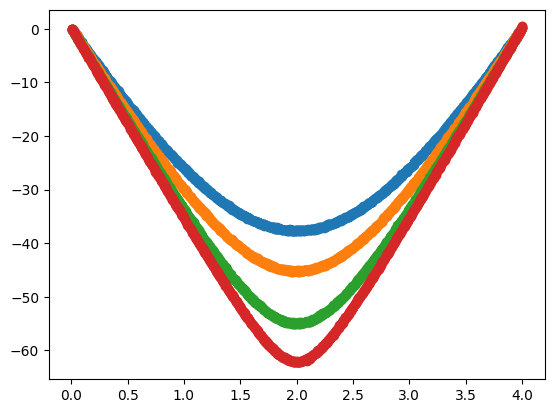

In [7]:
sample = 89
for j in range(4):
    plt.scatter(Data_3d[f"robot_pos_{j}"][sample][:,0],Data_3d[f"robot_pos_{j}"][sample][:,3])
    
plt.show()

In [8]:
def sample_random_segments_fn_3d(data, num_samples=5, segment_length=400):
    segments = []

    for i in range(len(data)):
        # Get the minimum trajectory length across all antennas
        length = min(
            len(data.robot_pos_0[i]),
            len(data.robot_pos_1[i]),
            len(data.robot_pos_2[i]),
            len(data.robot_pos_3[i])
        )

        for _ in range(num_samples):
            start_indices = random.sample(range(length - segment_length), 4)

            # Get the x offset from robot_pos_x with the minimum start pos so there wont be any negative trajectories
            min_start_pos = np.argmin(start_indices)
            x_offset = data[f"robot_pos_{min_start_pos}"][i][start_indices[min_start_pos]][0]  # initial x

            segmented_trajectory = []
            for j, start in enumerate(start_indices):
                end = start + segment_length
                segment = data[f"robot_pos_{j}"][i][start:end]

                # Subtract x_offset from each x in the segment
                adjusted_segment = [[x - x_offset, y, z, phase] for x, y, z, phase in segment]
                segmented_trajectory.append({f"robot_pos_{j}": adjusted_segment})

            # Adjust tag_pos x
            tag = data["tag_pos"][i]
            adjusted_tag = [tag[0] - x_offset, tag[1], tag[2]]
            segmented_trajectory.append({"tag_pos": adjusted_tag})

            segments.append(segmented_trajectory)

    return segments

In [9]:
# Sample random segments from all the data
random_segments_3d = sample_random_segments_fn_3d(Data_3d, num_samples= 5, segment_length= 400)
# Convert the list of segments to a DataFrame
random_segments_3d = pd.DataFrame(random_segments_3d)
random_segments_3d = random_segments_3d.apply(extract_dicts, axis=1)
random_segments_3d.head()

,robot_pos_0,robot_pos_1,robot_pos_2,robot_pos_3,tag_pos
0,"[[0.0, 0.0, 0.633, -1.6938370778430993], [0.00...","[[2.200974893079587, 0.0, 1.073, -44.180687997...","[[0.7083103259686395, 0.0, 1.528, -20.46468348...","[[1.1434442535003566, 0.0, 1.928, -25.76603204...","[1.9430996319096763, 0.1, 0.1]"
1,"[[0.6311303149157187, 0.0, 0.633, -22.21547658...","[[0.5062728815654447, 0.0, 1.073, -16.59422255...","[[0.0, 0.0, 1.528, -0.3698665608280294], [0.00...","[[1.7202236161927065, 0.0, 1.928, -31.22603714...","[1.9811501242925775, 0.1, 0.1]"
2,"[[0.5953828499451781, 0.0, 0.633, -20.33905101...","[[0.0, 0.0, 1.073, 0.0], [0.003452363044455926...","[[1.918225750860252, 0.0, 1.528, -37.097786415...","[[0.1924576590186417, 0.0, 1.928, -5.122719964...","[1.999611691392321, 0.1, 0.1]"
3,"[[1.785796755780643, 0.0, 0.633, -54.355019118...","[[0.40323361527162266, 0.0, 1.073, -24.2888578...","[[0.0, 0.0, 1.528, -10.721522807762284], [0.00...","[[0.39580670653350475, 0.0, 1.928, -18.3628779...","[1.6184143455514808, 0.1, 0.1]"
4,"[[0.8307952025727903, 0.0, 0.633, -35.38427945...","[[1.7397377046800984, 0.0, 1.073, -45.32065990...","[[0.0, 0.0, 1.528, -6.247831016431746], [0.002...","[[1.9969741986175629, 0.0, 1.928, -31.29907281...","[1.7779565996890534, 0.1, 0.1]"


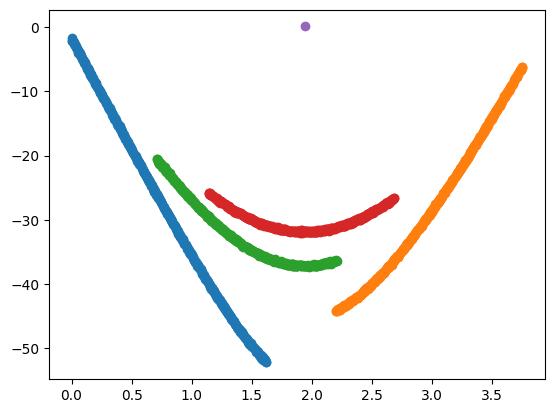

In [10]:
sample = 0
for i in range(4):
    arr = np.array(random_segments_3d[f'robot_pos_{i}'][sample])
    plt.scatter(arr[:,0], arr[:,3])
plt.scatter(random_segments_3d["tag_pos"][sample][0], random_segments_3d["tag_pos"][sample][1])
plt.show()

In [20]:
#Find the mean of the first element of the tag_pos
mean_tag_x = random_segments_3d["tag_pos"].apply(lambda x: x[0]).mean()
#Find the std of the first element of the tag_pos
std_tag_x = random_segments_3d["tag_pos"].apply(lambda x: x[0]).std()
max_tag_x = random_segments_3d["tag_pos"].apply(lambda x: x[0]).max()
min_tag_x = random_segments_3d["tag_pos"].apply(lambda x: x[0]).min()

mean_tag_x, std_tag_x, max_tag_x, min_tag_x

(np.float64(1.5158259848181164),
 np.float64(0.3916448834939971),
 np.float64(2.0000696299272978),
 np.float64(-0.2275713197174345))

In [21]:
def lin_interpolation_3d(data, length = 385, num_of_antennas = 4):
    for i in range(len(data)):
        for j in range(num_of_antennas):
            robot_pos = np.array(data.loc[i, f'robot_pos_{j}'])
            x = robot_pos[:, 0]
            y = robot_pos[:, 1]
            phase = robot_pos[:, 2]
            z = robot_pos[:, 3]


            if len(phase) != len(x):
                print(f"Skipping segment {i,j}: len(x)={len(x)} != len(phase)={len(phase)}")
                continue

            xd = np.linspace(x[0], x[-1], length)

            y_interp = interp1d(x, y, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)
            z_interp = interp1d(x, z, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)
            phase_interp = interp1d(x, phase, kind='linear', bounds_error=False, fill_value="extrapolate")(xd)

            data.loc[i, f'robot_pos_{j}'] = np.vstack((xd, y_interp, phase_interp, z_interp)).T

    return data


In [22]:
interpolated_segments = lin_interpolation_3d(random_segments_3d, length=385)
interpolated_segments.head()

,robot_pos_0,robot_pos_1,robot_pos_2,robot_pos_3,tag_pos
0,"[[0.0, 0.0, 0.633, -1.6938370778430993], [0.00...","[[2.200974893079587, 0.0, 1.073, -44.180687997...","[[0.7083103259686395, 0.0, 1.528, -20.46468348...","[[1.1434442535003566, 0.0, 1.928, -25.76603204...","[1.9430996319096763, 0.1, 0.1]"
1,"[[0.6311303149157187, 0.0, 0.633, -22.21547658...","[[0.5062728815654447, 0.0, 1.073, -16.59422255...","[[0.0, 0.0, 1.528, -0.3698665608280294], [0.00...","[[1.7202236161927065, 0.0, 1.928, -31.22603714...","[1.9811501242925775, 0.1, 0.1]"
2,"[[0.5953828499451781, 0.0, 0.633, -20.33905101...","[[0.0, 0.0, 1.073, 0.0], [0.003840281074581569...","[[1.918225750860252, 0.0, 1.528, -37.097786415...","[[0.1924576590186417, 0.0, 1.928, -5.122719964...","[1.999611691392321, 0.1, 0.1]"
3,"[[1.785796755780643, 0.0, 0.633, -54.355019118...","[[0.40323361527162266, 0.0, 1.073, -24.2888578...","[[0.0, 0.0, 1.528, -10.721522807762284], [0.00...","[[0.39580670653350475, 0.0, 1.928, -18.3628779...","[1.6184143455514808, 0.1, 0.1]"
4,"[[0.8307952025727903, 0.0, 0.633, -35.38427945...","[[1.7397377046800984, 0.0, 1.073, -45.32065990...","[[0.0, 0.0, 1.528, -6.247831016431746], [0.003...","[[1.9969741986175629, 0.0, 1.928, -31.29907281...","[1.7779565996890534, 0.1, 0.1]"


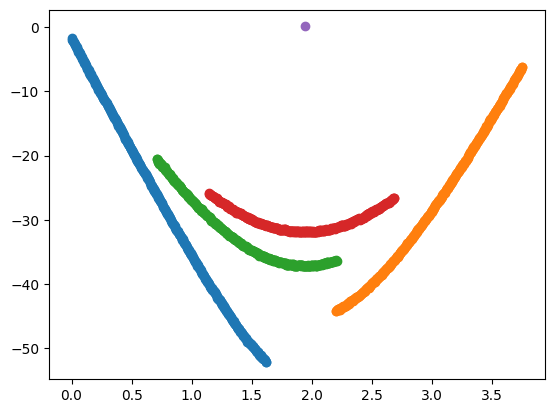

In [23]:
sample = 0
for i in range(4):
    arr = np.array(interpolated_segments[f'robot_pos_{i}'][sample])
    plt.scatter(arr[:,0], arr[:,3])
plt.scatter(interpolated_segments["tag_pos"][sample][0], interpolated_segments["tag_pos"][sample][1])
plt.show()

In [25]:
num_of_antennas = 4
final_tensor = []


for i in range(len(interpolated_segments)):
    antenna_array = []
    for j in range(num_of_antennas):
        antenna_array.append({
            'Antenna' : j + 1,
            'path' : interpolated_segments[f"robot_pos_{j}"][i],
            'tag_name' : i,
            'tag_pos' : interpolated_segments["tag_pos"][i]
        })
    final_tensor.append(antenna_array)

final_tensor[:3]

[[{'Antenna': 1,
   'path': array([[ 0.00000000e+00,  0.00000000e+00,  6.33000000e-01,
           -1.69383708e+00],
          [ 4.22228965e-03,  0.00000000e+00,  6.33000000e-01,
           -2.06754418e+00],
          [ 8.44457930e-03,  0.00000000e+00,  6.33000000e-01,
           -2.14398618e+00],
          ...,
          [ 1.61291465e+00,  0.00000000e+00,  6.33000000e-01,
           -5.18495474e+01],
          [ 1.61713694e+00,  0.00000000e+00,  6.33000000e-01,
           -5.20450846e+01],
          [ 1.62135923e+00,  0.00000000e+00,  6.33000000e-01,
           -5.21970860e+01]], shape=(385, 4)),
   'tag_name': 0,
   'tag_pos': [np.float64(1.9430996319096763),
    np.float64(0.1),
    np.float64(0.1)]},
  {'Antenna': 2,
   'path': array([[  2.20097489,   0.        ,   1.073     , -44.180688  ],
          [  2.20502039,   0.        ,   1.073     , -44.21069206],
          [  2.20906589,   0.        ,   1.073     , -44.08935475],
          ...,
          [  3.74635568,   0.        ,   1.

In [28]:
import pickle
with open(os.path.join(parent_dir,f"Sim_Data_3D_{len(final_tensor)}.pkl"),'wb') as f:
    pickle.dump(final_tensor,f)